In [21]:
import tensorflow as tf
import os
from numpy import *
from pandas import *
import matplotlib.pyplot as plt
import imghdr
import warnings as wr
wr.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
import cv2
from tensorflow.keras.metrics import Precision,Recall,Accuracy
from tensorflow.keras.models import load_model

In [2]:
#making gpus ready

#adding gpus
gpus=tf.config.experimental.list_physical_devices('GPU')
#memory setting for gpus
for i in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
#path setting
path_cls=os.path.join('Gender_data')
lables=os.listdir(path_cls)
lables

['Female', 'Male']

In [4]:
#select only images with needed extenction remove remaining
l=['jpg','png','jpeg']
for image_class in lables:
    for images in os.listdir(os.path.join(path_cls,image_class)): #gives list of directories in that path or directory
        imgs=os.path.join(path_cls,image_class,images)
        try:
            org_img=plt.imread(imgs)
            tip=imghdr.what(imgs) #image header directory to optain the extension
            if (tip not in l):
                print('Not in needed format')
                os.remove(imgs)
        except Exception as e:
            print(e)

In [5]:
data=tf.keras.utils.image_dataset_from_directory(path_cls)
#data
#iter_img=data.as_numpy_iterator()
#batch=iter_img.next()
#batch[0].shape

Found 160 files belonging to 2 classes.


In [6]:
#preprocess images and bring batches to pipelines
data=data.map(lambda x,y:(x/255,y))
iter_img=data.as_numpy_iterator()
batch=iter_img.next()
batch[0].shape

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


(32, 256, 256, 3)

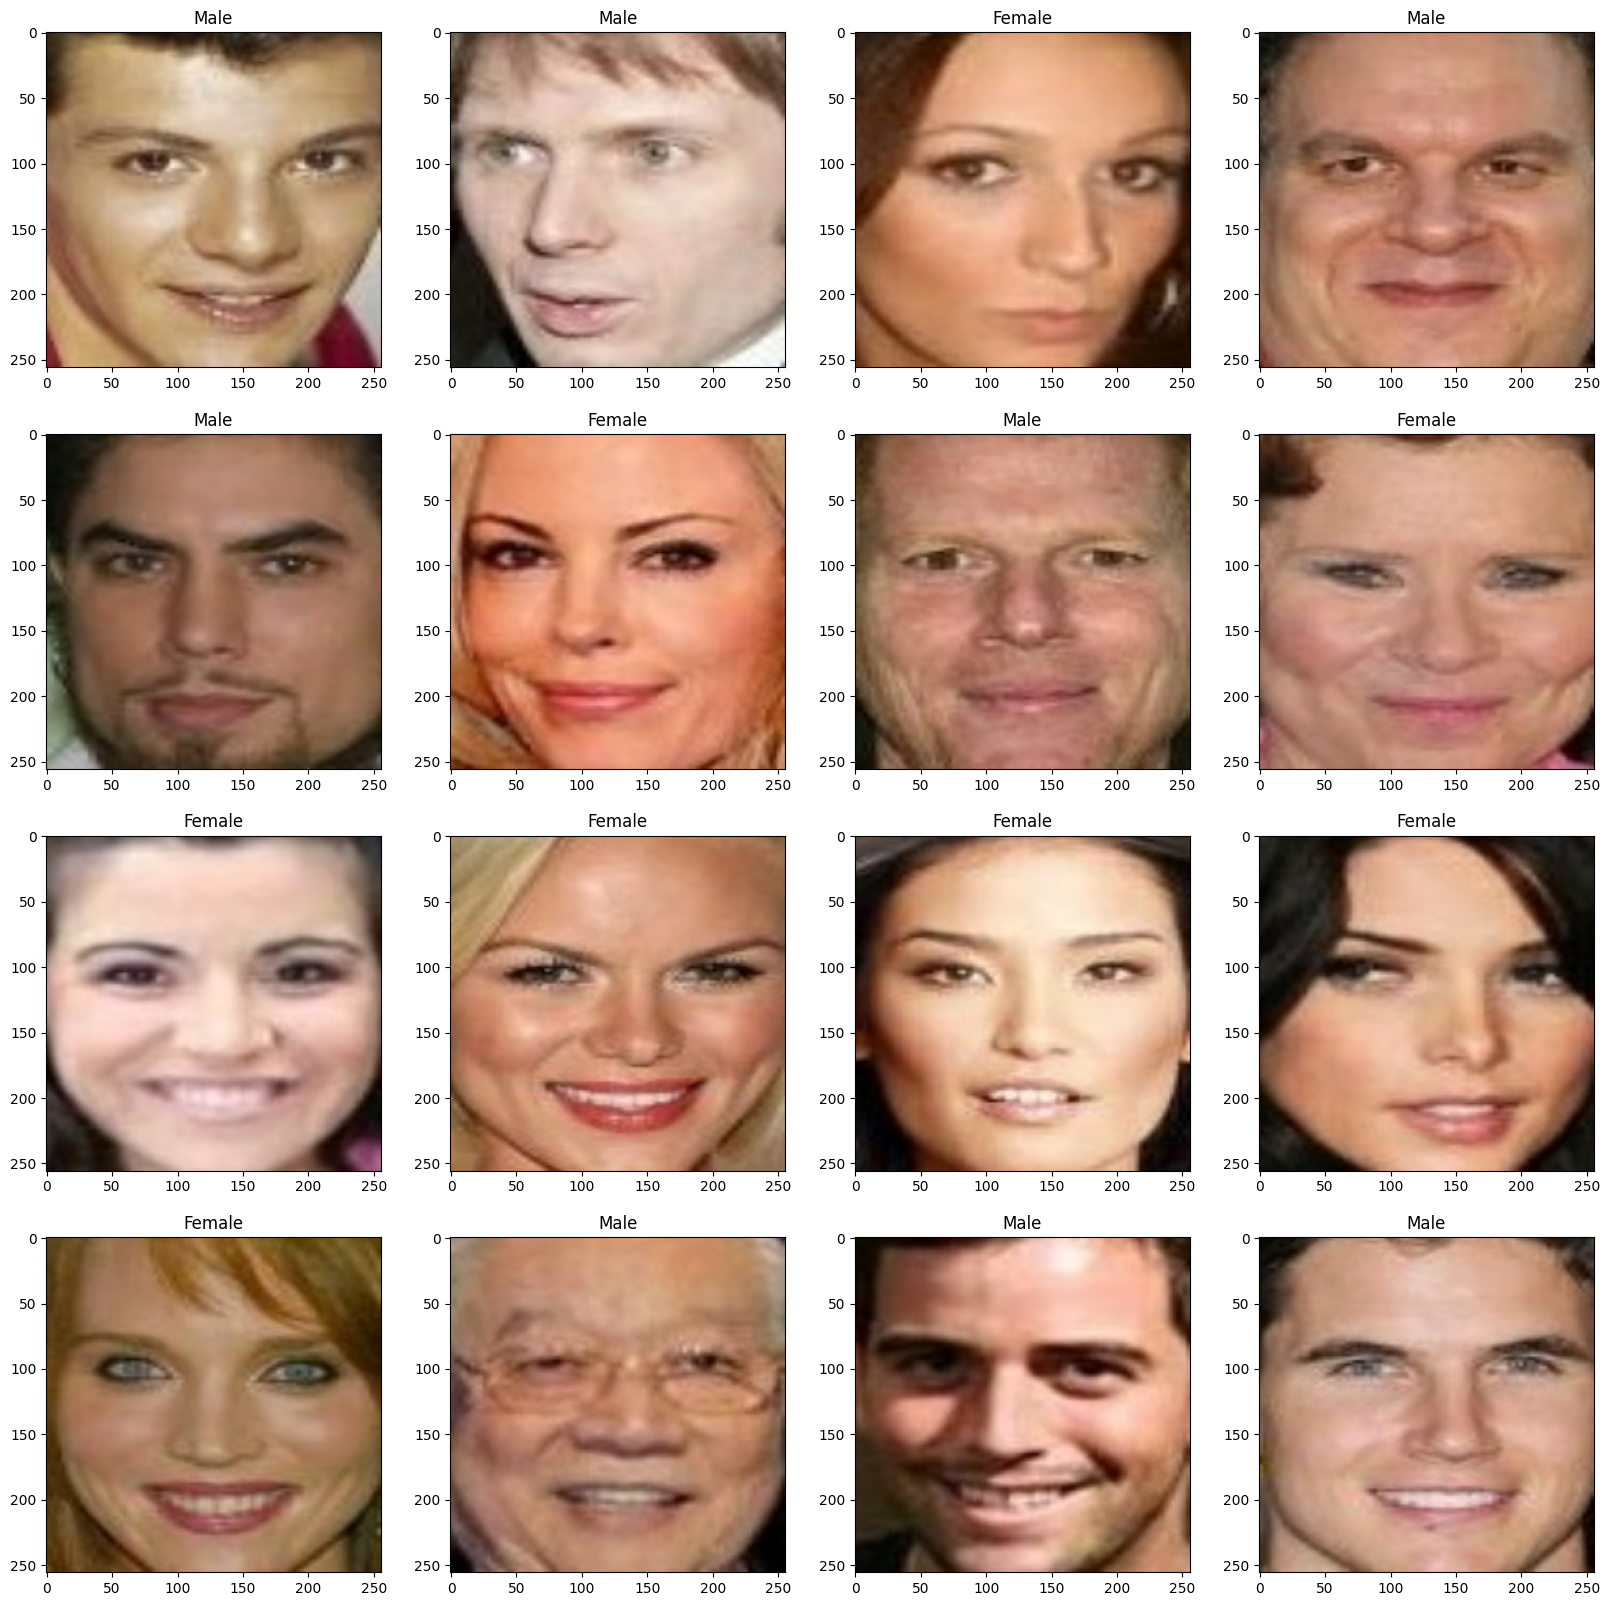

In [7]:
#ploting images using subplots
fig,ax=plt.subplots(nrows=4,ncols=4,figsize=(20,20))
ax=ax.flatten()
for i,j in enumerate(batch[0][:16]):
    ax[i].imshow(j)
    ax[i].title.set_text(lables[batch[1][i]])

In [8]:
print(len(data))

5


In [9]:
#splitting training and testing sets using skip and take methods
train_per=int(0.7*len(data))
test_per=int(0.1*len(data))
valid_per=int(0.2*len(data))
train_data=data.take(train_per)
test_data=data.skip(train_per).take(test_per)
valid_data=data.skip(train_per+test_per).take(valid_per)
len(test_data)

0

In [10]:
#object creation
model=Sequential()

#adding input layer functionality to convolution layer
model.add(Conv2D(16,(3,3),1,activation='ReLU',input_shape=(256,256,3))) #16 --> filters (3,3) --> Kernal size 1 --> slides
model.add(MaxPooling2D())

#adding hidden layers
model.add(Conv2D(32,(3,3),1,activation='ReLU'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='ReLU'))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='ReLU'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation='ReLU'))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation='ReLU'))
model.add(MaxPooling2D())

#adding flatten layer
model.add(Flatten()) # to flatten 4x4 matrix as 4x1 matrix for example

#adding output layers
model.add(Dense(256,activation='ReLU'))
model.add(Dense(1,activation='sigmoid'))

In [11]:
#compiling the model using optimizer and loss function
model.compile(optimizer='adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [15]:
history=model.fit(train_data,epochs=20,validation_data=valid_data)

Epoch 1/20
3/3 [==============================] - 5s 2s/step - loss: 0.6908 - accuracy: 0.5104 - val_loss: 0.6937 - val_accuracy: 0.4375
Epoch 2/20
3/3 [==============================] - 5s 2s/step - loss: 0.6917 - accuracy: 0.4688 - val_loss: 0.6905 - val_accuracy: 0.6250
Epoch 3/20
3/3 [==============================] - 5s 2s/step - loss: 0.6920 - accuracy: 0.5625 - val_loss: 0.6920 - val_accuracy: 0.5312
Epoch 4/20
3/3 [==============================] - 5s 2s/step - loss: 0.6915 - accuracy: 0.5521 - val_loss: 0.6867 - val_accuracy: 0.6562
Epoch 5/20
3/3 [==============================] - 5s 2s/step - loss: 0.6889 - accuracy: 0.5833 - val_loss: 0.6850 - val_accuracy: 0.7812
Epoch 6/20
3/3 [==============================] - 4s 2s/step - loss: 0.6876 - accuracy: 0.6458 - val_loss: 0.6839 - val_accuracy: 0.6562
Epoch 7/20
3/3 [==============================] - 5s 2s/step - loss: 0.6845 - accuracy: 0.6354 - val_loss: 0.6848 - val_accuracy: 0.6562
Epoch 8/20
3/3 [=========================

In [16]:
pr=Precision()
re=Recall()
acu=Accuracy()

In [23]:
for i in test_data.as_numpy_iterator(): 
    X, y = i   #X->holds images #y->holds lables
    res = model.predict(X)  #32 predictions for test data
    pr.update_state(y, res)
    re.update_state(y, res)
    acu.update_state(y, res)
print(pr.result(), re.result(), acu.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


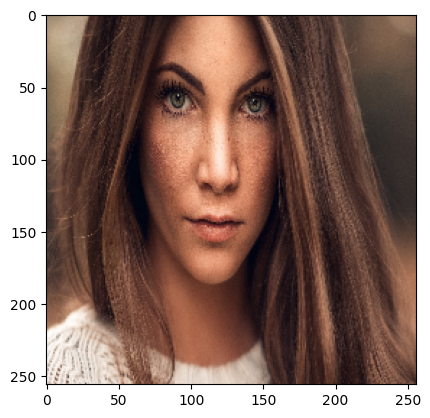

1/1 [==============================] - 0s 135ms/step
[[0.98515147]]
Female


In [22]:
img=plt.imread('female.jpg')
plt.imshow(img)

#resize according to layers
resize=tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int)) #adjusted according to RGB b/w 0 to 1
plt.show()

#optimize the new image
resize=resize/255
#expand your image array
img=expand_dims(resize,0)

#prediction
pred=model.predict(img)
print(pred)

#since it is a binary classification

if pred[0]>0.5:
    print("Female")
else:
    print("Male")

model.save(os.path.join('Gender image classification.h5'))
